In [2]:
%matplotlib inline

If the `econml` and `wget` python packages are not installed on your machine install them by running the cells below.

In [3]:
!pip install econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.4 MB/s eta 0:00:00


Importing all the necessary components

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import pandas as pd
import glob

upload csv_file

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
!ls /content/drive/MyDrive/Econ_thesis

econ.ipynb	      テレビCM出稿データ_2025.csv    メインデータ_2025.csv
Web利用状況_2025.csv  テレビ番組別視聴状況_2025.csv  雑誌閲読状況_2025.csv


In [16]:
# 読み込みたいCSVが入っているフォルダのパス
folder_path = "/content/drive/MyDrive/Econ_thesis"

# フォルダ内のCSVファイル一覧を取得
csv_files = glob.glob(folder_path + '/*.csv')

dataframes_local = {}  # 辞書を初期化

# 各CSVファイルを読み込み
for path in csv_files:
    fn = path.split('/')[-1]               # ファイル名（例: sample.csv）
    df_name = fn.split('.')[0]              # 拡張子を除いた名前（辞書のキー用）

    try:
        dataframes_local[df_name] = pd.read_csv(path)
        print(f"CSVファイル '{fn}' をGoogle Driveから読み込みました。")
        display(dataframes_local[df_name].head())
    except Exception as e:
        print(f"CSVファイル '{fn}' の読み込み中にエラーが発生しました: {e}")

CSVファイル 'Web利用状況_2025.csv' をGoogle Driveから読み込みました。


,SampleID,PC_01_MA,PC_02_MA,PC_03_MA,PC_04_MA,PC_05_MA,PC_06_MA,PC_07_MA,PC_08_MA,PC_09_MA,...,CAT_INFO_15_05_MX,CAT_INFO_15_06_MX,CAT_INFO_15_07_MX,CAT_INFO_16_01_MX,CAT_INFO_16_02_MX,CAT_INFO_16_03_MX,CAT_INFO_16_04_MX,CAT_INFO_16_05_MX,CAT_INFO_16_06_MX,CAT_INFO_16_07_MX
0,1530001,1,0,0,0,1,1,1,0,0,...,0,0,1,1,1,0,0,0,0,0
1,1530002,1,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,1530003,1,1,1,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1530007,1,1,0,1,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
4,1530011,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


CSVファイル 'テレビCM出稿データ_2025.csv' をGoogle Driveから読み込みました。


,title_code_variable,title_code,column_ch,column_text,tv_day_text,title_name,rating_all,cm_code,item_name,company_name,broadcast_date,broadcast_start_time,cm_airtime
0,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1895275,番宣,番宣,2025/1/4,4:43:03,30
1,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1894372,番宣,番宣,2025/1/4,4:43:33,30
2,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1894383,番宣,番宣,2025/1/4,4:54:33,30
3,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1891982,番宣,番宣,2025/1/4,5:02:52,30
4,TVWatch.42501040443,4.250104e+10,4,日本テレビ,2025/1/4,日テレポシュレ 冬のホリデーシーズンＳＰ［再］,0.0,1895272,番宣,番宣,2025/1/4,5:11:33,30


CSVファイル 'テレビ番組別視聴状況_2025.csv' をGoogle Driveから読み込みました。


,SampleID,TVWatch.12501010453,TVWatch.12501010454,TVWatch.12501010500,TVWatch.12501010510,TVWatch.12501010600,TVWatch.12501010610,TVWatch.12501010655,TVWatch.12501010657,TVWatch.12501010700,...,TVWatch.122503152230,TVWatch.122503152300,TVWatch.122503152330,TVWatch.122503152400,TVWatch.122503152425,TVWatch.122503152455,TVWatch.122503152525,TVWatch.122503152550,TVWatch.122503152615,TVWatch.122503152645
0,1530001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1530002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1530003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1530007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1530011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


CSVファイル 'メインデータ_2025.csv' をGoogle Driveから読み込みました。


,SampleID,SEX_CD,AGE,MARRIAGE,CHILD_CD,CHILD_CD2,CHILD_AGE_1,CHILD_AGE_2,CHILD_AGE_3,CHILD_AGE_4,...,PI_Scale_16_02_MX,PI_Scale_16_03_MX,PI_Scale_16_04_MX,PI_Scale_16_05_MX,PI_Scale_16_06_MX,PI_Scale_16_07_MX,PI_Scale_16_08_MX,PI_Scale_16_09_MX,PI_Scale_16_10_MX,PI_Scale_16_11_MX
0,1530001,1,43,1,2,5,,,,,...,1,1,0,0,0,0,0,0,0,0
1,1530002,1,52,2,1,2,17,13,,,...,0,1,1,0,0,0,0,0,0,0
2,1530003,1,52,1,2,5,,,,,...,0,0,0,0,0,0,0,0,0,1
3,1530007,1,54,2,2,5,,,,,...,0,0,0,0,0,0,0,0,0,1
4,1530011,1,57,2,1,1,16,,,,...,0,0,0,1,0,0,1,0,0,0


CSVファイル '雑誌閲読状況_2025.csv' をGoogle Driveから読み込みました。


,SampleID,MZ.2740390,MZ.2700404,MZ.0040488,MZ.1590383,MZ.2180464,MZ.2820489,MZ.2790489,MZ.2680448,MZ.0480441,...,MZ.1230243,MZ.2140494,MZ.2730492,MZ.2770487,MZ.2760488,MZ.2780490,MZ.2720488,MZ.2710488,MZ.2380244,MZ.0250268
0,1530001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1530002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1530003,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1530007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1530011,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# データ特徴の閲覧

for df_name, df in dataframes_local.items():
    print(f'▼ {df_name} の情報 ---------------------')
    print(df.info())
    print(f'行数と列数: {df.shape}')  # (行数, 列数)
    print('\n')  # 区切り

for name, df in dataframes_local.items():
    print(f'▼ {name} の統計量（すべての型）---------------------')
    print(df.describe(include='all'))
    print('\n')


for name, df in dataframes_local.items():
    print(f'▼ {name} の欠損値数')
    print(df.isnull().sum())
    print('\n')

メインデータに対してのコード

In [17]:
# Access the dataframe from the dictionary
df_main = dataframes_local['メインデータ_2025']

# 2. 対象列を抽出（AAQ列からBHQ列まで）
target_columns = df_main.loc[:, "PI_01_B00000474":"PS_02_B00005657"]

# 対象列のデータ型を確認
print(target_columns.dtypes)

# 対象列を数値型に変換
target_columns = target_columns.apply(pd.to_numeric, errors='coerce')

# データ型を確認（すべてfloatなどになっているはず）
print(target_columns.dtypes)

#欠損値の有無を確認
print(target_columns.isnull().sum())


PI_01_B00000474    object
PS_01_B00000474    object
PI_02_B00000474    object
PS_02_B00000474    object
PI_01_B00000720    object
                    ...  
PS_02_B00005635    object
PI_01_B00005657    object
PS_01_B00005657    object
PI_02_B00005657    object
PS_02_B00005657    object
Length: 844, dtype: object
PI_01_B00000474    float64
PS_01_B00000474    float64
PI_02_B00000474    float64
PS_02_B00000474    float64
PI_01_B00000720    float64
                    ...   
PS_02_B00005635    float64
PI_01_B00005657    float64
PS_01_B00005657    float64
PI_02_B00005657    float64
PS_02_B00005657    float64
Length: 844, dtype: object
PI_01_B00000474    122
PS_01_B00000474    122
PI_02_B00000474     48
PS_02_B00000474     48
PI_01_B00000720    140
                  ... 
PS_02_B00005635    136
PI_01_B00005657     89
PS_01_B00005657     89
PI_02_B00005657    195
PS_02_B00005657    195
Length: 844, dtype: int64


In [18]:

# 各種統計量を計算
mean_values = target_columns.mean()
min_values = target_columns.min()
median_values = target_columns.median()
max_values = target_columns.max()

summary = pd.DataFrame({
    "mean": mean_values,
    "min": min_values,
    "median": median_values,
    "max": max_values
})

print(summary)



# 平均値が高い順に20個取り出す
highest_mean_20 = summary.sort_values(by="mean", ascending=False).head(20)

print(highest_mean_20)


                     mean  min  median  max
PI_01_B00000474  2.447855  1.0     2.0  4.0
PS_01_B00000474  3.490328  1.0     4.0  5.0
PI_02_B00000474  2.410277  1.0     2.0  4.0
PS_02_B00000474  3.398858  1.0     4.0  5.0
PI_01_B00000720  2.962712  1.0     3.0  4.0
...                   ...  ...     ...  ...
PS_02_B00005635  3.067259  1.0     3.0  4.0
PI_01_B00005657  3.185815  1.0     3.0  4.0
PS_01_B00005657  3.668602  1.0     4.0  4.0
PI_02_B00005657  3.047289  1.0     3.0  4.0
PS_02_B00005657  3.562690  1.0     4.0  4.0

[844 rows x 4 columns]
                     mean  min  median  max
PI_02_B00002802  5.806466  1.0     6.0  7.0
PI_01_B00002802  5.803412  1.0     6.0  7.0
PI_02_B00002803  5.799180  1.0     6.0  7.0
PI_02_B00002801  5.795537  1.0     6.0  7.0
PI_01_B00002801  5.787207  1.0     6.0  7.0
PI_01_B00002803  5.786354  1.0     6.0  7.0
PI_01_B00004567  5.120446  1.0     5.0  6.0
PI_02_B00004567  5.073149  1.0     5.0  6.0
PI_01_B00004568  5.072868  1.0     5.0  6.0
PI_02_B0

In [19]:
# 見たい指標（列名）のリスト
cols = [
    "PI_01_B00001262",
    "PS_01_B00001262",
    "PI_02_B00001262",
    "PS_02_B00001262"
]

# summaryから該当行を抜き出す
selected = summary.loc[cols]

print(selected)


                     mean  min  median  max
PI_01_B00001262  3.088248  1.0     3.0  5.0
PS_01_B00001262  4.861689  1.0     5.0  6.0
PI_02_B00001262  3.096299  1.0     3.0  5.0
PS_02_B00001262  4.901177  1.0     5.0  6.0


テレビ視聴状況CSVに対してのコード

テレビ視聴状況のdataframeから必要な列だけを取得して、新しいdataframeであるtvwatchを作成する

In [20]:
# Access the dataframe from the dictionary
df_sub1 = dataframes_local['テレビ番組別視聴状況_2025']
df_sub2 = dataframes_local['テレビCM出稿データ_2025']


# 「item_name」列に「Newヤクルト カロリーハーフ」を含む行を抽出し、「title_code_variable」列だけ取得
yakult_titlecodes = df_sub2.loc[
    df_sub2['item_name'].str.contains('Newヤクルト カロリーハーフ', na=False),
    'title_code_variable'
]

#seriesをリストに変換
yakult_titlecodes_list = yakult_titlecodes.tolist()


# df_sub1の最初の列名を取得
first_col = df_sub1.columns[0]

# 最初の列と yakult_titlecodes の列をまとめて選択
tv_watch = df_sub1[[first_col] + yakult_titlecodes_list]

# 各参加者の該当番組の視聴回数を合計
watch_sum = tv_watch[yakult_titlecodes_list].sum(axis=1)

# 合計列を追加
tv_watch['視聴番組数'] = watch_sum

# 確認
display(tv_watch.head())

# 参加者の該当番組の視聴数が０か1以上かでダミー変数を作り、列に追加
tv_watch.loc[tv_watch['視聴番組数'] >= 1, '視聴番組フラグ'] = 1
tv_watch.loc[tv_watch['視聴番組数'] < 1, '視聴番組フラグ'] = 0

# 確認
display(tv_watch[["SampleID", '視聴番組数', '視聴番組フラグ']].head())

# 追加したい列名リスト
add_cols = [
    "PI_01_B00001262",
    "PS_01_B00001262",
    "PI_02_B00001262",
    "PS_02_B00001262"
]

# df_mainから該当列だけ抜き出し
df_add = df_main[add_cols]

# tvwatchに横方向で追加
tv_watch = pd.concat([tv_watch, df_add], axis=1)

# 確認
display(tv_watch.head())


/tmp/ipython-input-3300545096.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_watch['視聴番組数'] = watch_sum


,SampleID,TVWatch.42501060700,TVWatch.42501060700,TVWatch.42501061355,TVWatch.42501061550,TVWatch.62501062200,TVWatch.82501060950,TVWatch.82501061545,TVWatch.82501061545,TVWatch.82501062300,...,TVWatch.102501311453,TVWatch.102501311550,TVWatch.102501312315,TVWatch.122501311113,TVWatch.102501312445,TVWatch.42502050700,TVWatch.42502120700,TVWatch.42502190700,TVWatch.42502260700,視聴番組数
0,1530001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1530002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,16
2,1530003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
3,1530007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
4,1530011,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,32


/tmp/ipython-input-3300545096.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_watch.loc[tv_watch['視聴番組数'] >= 1, '視聴番組フラグ'] = 1


,SampleID,視聴番組数,視聴番組フラグ
0,1530001,0,0.0
1,1530002,16,1.0
2,1530003,13,1.0
3,1530007,15,1.0
4,1530011,32,1.0


,SampleID,TVWatch.42501060700,TVWatch.42501060700,TVWatch.42501061355,TVWatch.42501061550,TVWatch.62501062200,TVWatch.82501060950,TVWatch.82501061545,TVWatch.82501061545,TVWatch.82501062300,...,TVWatch.42502050700,TVWatch.42502120700,TVWatch.42502190700,TVWatch.42502260700,視聴番組数,視聴番組フラグ,PI_01_B00001262,PS_01_B00001262,PI_02_B00001262,PS_02_B00001262
0,1530001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,4,5,4,5
1,1530002,0,0,0,0,0,0,0,0,0,...,0,0,1,0,16,1.0,5,5,5,5
2,1530003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13,1.0,5,5,5,6
3,1530007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,15,1.0,4,6,3,6
4,1530011,0,0,0,0,0,1,0,0,0,...,0,0,0,0,32,1.0,3,5,3,5


,SampleID,視聴番組数
0,1530001,0
1,1530002,16
2,1530003,13
3,1530007,15
4,1530011,32
...,...,...
2495,1534020,0
2496,1534022,0
2497,1534024,0
2498,1534027,12


視聴番組数
0      656
1      186
2      162
3      163
4      128
      ... 
69       1
80       1
88       1
91       1
216      1
Length: 64, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35222 (\N{CJK UNIFIED IDEOGRAPH-8996}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32884 (\N{CJK UNIFIED IDEOGRAPH-8074}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30058 (\N{CJK UNIFIED IDEOGRAPH-756A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32068 (\N{CJK UNIFIED IDEOGRAPH-7D44}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas

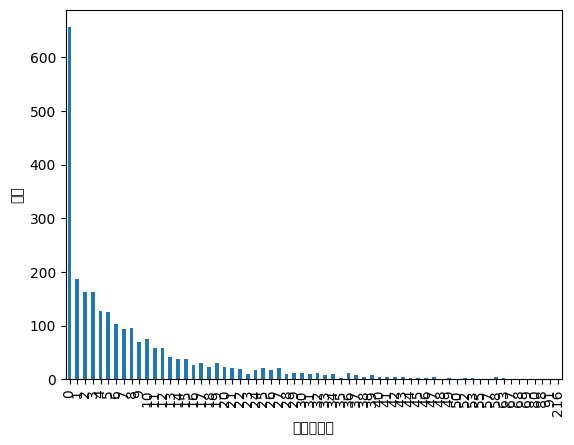

In [21]:
#IDと視聴合計数の表示
display(tv_watch[["SampleID", '視聴番組数']])


#視聴番組数別の人数を表示
counts = tv_watch.groupby('視聴番組数').size()
print(counts)
counts.plot(kind='bar')
plt.xlabel('視聴番組数')
plt.ylabel('人数')
plt.show()

### 購買意欲に対してのデータセット

In [22]:
#欲しいDataframeだけを抽出

# 抜き出したい列名をリストで指定
select_cols = ['SampleID', '視聴番組フラグ', 'PI_01_B00001262', 'PI_02_B00001262']

# 指定列だけ抜き出して新しいDataFrameを作成
tv_watch_selected = tv_watch[select_cols]

# 確認
display(tv_watch_selected.head())

,SampleID,視聴番組フラグ,PI_01_B00001262,PI_02_B00001262
0,1530001,0.0,4,4
1,1530002,1.0,5,5
2,1530003,1.0,5,5
3,1530007,1.0,4,3
4,1530011,1.0,3,3


In [23]:
# ワイドデータをロングデータに変換
tv_watch_PI_long = pd.melt(
    tv_watch_selected,                       # ①変換したいデータフレーム
    id_vars=['SampleID', '視聴番組フラグ'],  # ②「行ごとに固定」しておく列名（＝変えない列）
    value_vars=['PI_01_B00001262', 'PI_02_B00001262'],  # ③「縦持ち」にしたい列（＝ここが“時期”に化ける）
    var_name='時期',                        # ④「どの列だったか」を書き出す新しい列名
    value_name='アウトカム'                  # ⑤「実際の値」を書き出す新しい列名
)

#時期を文字から0と1に変更
tv_watch_PI_long['時期'] = tv_watch_PI_long['時期'].map({
    'PI_01_B00001262': 0,
    'PI_02_B00001262': 1
})

#アウトカムが文字列になっていたので、数値に変換
tv_watch_PI_long['アウトカム'] = pd.to_numeric(tv_watch_PI_long['アウトカム'], errors='coerce')

display(tv_watch_PI_long.head())

#時期ごとにデータが半分になっていることの確認
print(tv_watch_PI_long['時期'].value_counts())


,SampleID,視聴番組フラグ,時期,アウトカム
0,1530001,0.0,0,4.0
1,1530002,1.0,0,5.0
2,1530003,1.0,0,5.0
3,1530007,1.0,0,4.0
4,1530011,1.0,0,3.0


時期
0    2500
1    2500
Name: count, dtype: int64


### 購買数に対してのデータセット

In [24]:
# 1. 抜き出したい列名をリストで指定
select_cols_ps = ['SampleID', '視聴番組フラグ', 'PS_01_B00001262', 'PS_02_B00001262']

# 2. 指定列だけ抜き出して新しいDataFrameを作成
tv_watch_ps_selected = tv_watch[select_cols_ps]


# 3. meltでロング形式に変換
tv_watch_ps_long = pd.melt(
    tv_watch_ps_selected,
    id_vars=['SampleID', '視聴番組フラグ'],
    value_vars=['PS_01_B00001262', 'PS_02_B00001262'],
    var_name='時期',
    value_name='アウトカム_PS'
)

# 4. 時期を0と1に変更
tv_watch_ps_long['時期'] = tv_watch_ps_long['時期'].map({
    'PS_01_B00001262': 0,
    'PS_02_B00001262': 1
})

# 5. アウトカム_PSが文字列になっていたので、数値に変換
tv_watch_ps_long['アウトカム_PS'] = pd.to_numeric(tv_watch_ps_long['アウトカム_PS'], errors='coerce')

# 6. 確認
display(tv_watch_ps_long.head())

# 7. 必要なデータセットになっていることの確認
print(tv_watch_ps_long['時期'].value_counts())

,SampleID,視聴番組フラグ,時期,アウトカム_PS
0,1530001,0.0,0,5.0
1,1530002,1.0,0,5.0
2,1530003,1.0,0,5.0
3,1530007,1.0,0,6.0
4,1530011,1.0,0,5.0


時期
0    2500
1    2500
Name: count, dtype: int64


DIDを実行

$$
\begin{align*}
  \text{アウトカム}_{it} &= \beta_0 + \beta_1 \cdot \text{視聴番組フラグ}_i + \beta_2 \cdot \text{時期}_t \\
  &\quad + \beta_3 \cdot (\text{視聴番組フラグ}_i \times \text{時期}_t) + \varepsilon_{it} \\
  \\
  i\ &: \text{個人（SampleID）} \\
  t\ &: \text{時期（0:前, 1:後）}
\end{align*}
$$


購買意欲に対してのDID

In [25]:
import statsmodels.formula.api as smf

# 1. データ確認（念のため）
print(tv_watch_PI_long.head())

# 2. 回帰式でDID
# '視聴番組フラグ'がグループ（0=対照, 1=処置）、'時期'が時点（0=前, 1=後）
model = smf.ols('アウトカム ~ 視聴番組フラグ * 時期', data=tv_watch_PI_long).fit()

# 3. 結果表示
print(model.summary())

# DID推定値（交互作用の係数）
print('\nDID推定値:', model.params['視聴番組フラグ:時期'])


   SampleID  視聴番組フラグ  時期  アウトカム
0   1530001      0.0   0    4.0
1   1530002      1.0   0    5.0
2   1530003      1.0   0    5.0
3   1530007      1.0   0    4.0
4   1530011      1.0   0    3.0
                            OLS Regression Results                            
Dep. Variable:                  アウトカム   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     21.16
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           1.30e-13
Time:                        08:34:49   Log-Likelihood:                -7421.4
No. Observations:                4735   AIC:                         1.485e+04
Df Residuals:                    4731   BIC:                         1.488e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 c

購買数に対してのDID

In [26]:
# 1. データ確認（念のため）
print(tv_watch_ps_long.head())

# 2. 回帰式でDID
# '視聴番組フラグ'がグループ（0=対照, 1=処置）、'時期'が時点（0=前, 1=後）
model = smf.ols('アウトカム_PS ~ 視聴番組フラグ * 時期', data=tv_watch_ps_long).fit()

# 3. 結果表示
print(model.summary())

# DID推定値（交互作用の係数）
print('\nDID推定値:', model.params['視聴番組フラグ:時期'])


   SampleID  視聴番組フラグ  時期  アウトカム_PS
0   1530001      0.0   0       5.0
1   1530002      1.0   0       5.0
2   1530003      1.0   0       5.0
3   1530007      1.0   0       6.0
4   1530011      1.0   0       5.0
                            OLS Regression Results                            
Dep. Variable:               アウトカム_PS   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     24.66
Date:                Mon, 18 Aug 2025   Prob (F-statistic):           7.89e-16
Time:                        08:34:52   Log-Likelihood:                -6300.6
No. Observations:                4735   AIC:                         1.261e+04
Df Residuals:                    4731   BIC:                         1.263e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         


購買意欲　順序データということを考慮して、累積確率を使用した場合

In [ ]:

import statsmodels.api as sm

# =========================================
# 1) データ整形：wide -> long（DID用）
# =========================================
def prepare_long_for_DR_DID(
    df,
    treat_col='視聴番組フラグ',
    pre_col='PI_01_B00001262',
    post_col='PI_02_B00001262',
    id_col='SampleID'
):
    # 型の整理
    df = df[[id_col, treat_col, pre_col, post_col]].copy()
    df[treat_col] = (df[treat_col].astype(float)).astype(int)  # 0/1へ
    # long化
    long = pd.melt(
        df,
        id_vars=[id_col, treat_col],
        value_vars=[pre_col, post_col],
        var_name='wave',
        value_name='Y'
    )
    # Post (0=事前, 1=事後)
    wave_map = {pre_col: 0, post_col: 1}
    long['Post'] = long['wave'].map(wave_map).astype(int)
    long = long.drop(columns=['wave'])
    # 列リネーム（DIDの記号に合わせる）
    long = long.rename(columns={treat_col: 'Treat', id_col: 'cluster_id'})
    # Yは 0..5 の整数を想定
    long = long.dropna(subset=['Y'])
    long['Y'] = long['Y'].astype(int)
    return long

# =========================================
# 2) ロジット版 Distribution Regression DID
#    - しきい値 k=0..4 でロジット
#    - 予測確率から τ_k（累積のDID効果）を算出
#    - Δπ_j（カテゴリ別pp効果）を復元
#    - （任意）共変量 X_cols を追加可能
# =========================================
def dr_did_logit(
    long_df,
    X_cols=None,                 # 例: ['性別','年齢']（処置影響を受けないor事前値）
    cluster_col='cluster_id',
    thresholds=range(0,5)        # k=0..4
):
    X_cols = X_cols or []

    taus = []            # τ_k（累積のDID効果）を格納
    res_list = []        # 各kの回帰結果（必要なら参照）

    for k in thresholds:
        # しきい値ダミー Y^(k) = 1{Y <= k}
        yk = (long_df['Y'] <= k).astype(int).values

        # 設計行列 Z = [const, Treat, Post, Treat*Post, X...]
        Z = long_df[['Treat','Post'] + X_cols].copy()
        Z['TxP'] = Z['Treat'] * Z['Post']
        Z = sm.add_constant(Z, has_constant='add')

        # GLM-Binomial（ロジット）
        model = sm.GLM(yk, Z, family=sm.families.Binomial())
        # クラスタロバストSE：個体（SampleID）でクラスタ
        res = model.fit(cov_type='cluster', cov_kwds={'groups': long_df[cluster_col]})
        res_list.append(res)

        # 4セル（Treat,Post の組み合わせ）で予測確率を作る（AME/SAPE）
        def predict_prob(T, P):
            Ztmp = Z.copy()
            Ztmp['Treat'] = T
            Ztmp['Post']  = P
            Ztmp['TxP']   = T*P
            # GLMのpredictは平均（確率）を返す
            return res.predict(Ztmp).values  # 各iの確率（Xは観測のまま）

        p11 = predict_prob(1,1)
        p10 = predict_prob(1,0)
        p01 = predict_prob(0,1)
        p00 = predict_prob(0,0)

        tau_k = np.mean(p11 - p10 - (p01 - p00))   # 累積確率の差の差
        taus.append(tau_k)

    taus = np.array(taus)

    # カテゴリ別のpp効果 Δπ_j を復元（j=0..5）
    dppi = np.empty(6)
    dppi[0] = taus[0]
    for j in range(1,5):
        dppi[j] = taus[j] - taus[j-1]
    dppi[5] = -taus[-1]  # Pr(Y<=5)=1 の差の差は0 → 残り

    # 結果の表
    df_tau = pd.DataFrame({'k': list(thresholds), 'tau_k (ΔΔ Pr(Y≤k))': taus})
    df_cat = pd.DataFrame({
        'category j': [0,1,2,3,4,5],
        'Δπ_j (pp)': dppi
    })
    # 検算：Δπ_j の総和は0
    check_sum = dppi.sum()

    return df_tau, df_cat, check_sum, res_list

# =========================================
# 3) 使い方（あなたのデータ名に合わせて実行）
# =========================================
# 入力: tv_watch_selected（スクショのDataFrame）
long_df = prepare_long_for_DR_DID(
    tv_watch_selected,
    treat_col='視聴番組フラグ',
    pre_col='PI_01_B00001262',
    post_col='PI_02_B00001262',
    id_col='SampleID'
)

df_tau, df_cat, sum_check, _ = dr_did_logit(
    long_df,
    X_cols=[]          # 共変量があれば列名を入れる（例: ['性別','年齢_事前値']）
)

print('【累積のDID効果 τ_k】')
print(df_tau)
print('\n【カテゴリ別pp効果 Δπ_j】（合計は理論上0 → 検算=', round(sum_check, 12), ')')
print(df_cat)
